[link text](https://)# Data Analysis Plan: NFL QB Elo
## Team 17
- Kyle Sacks
- Aleksander Aguilar
- Narayan Sharma
- Reece Calvin

## Goal

Our team seeks to use the data provided by FiveThirtyEight, which lists every NFL game since 1950 and provides ELO for all QBs before and after each game, to answer two questions about NFL quarterbacks. 
1. Who is the most consistently good quarterback of all time? We will do this  by analyzing relative elo rating over many years and comparing QBs to their contemporaries.

2. How did the minimum standards for QBs grow each year? We will do this by analyzing the careers of QBs before their final year, and building a model to predict whether a given QB will retire.

## Data

Our dataset comes from one CSV file, but this file only contains information adjacent to what we actually want to analyze - the unprocessed file contains a list of every NFL game since 1920, with the teams and quarterbacks involved in the game, statistics about the elo of players, alongside other metrics. For our purposes, we need to convert this into a dataframe organized by player and by season, which relates their performance for that season by record, elo, and team.

First, we drop games which do not contain information about quarterbacks, and filter out the information which is irrelevant to our purposes. Then, we construct an intermediate dataframe which converts each line to be a game from each qb's perspective(so each game will appear twice, once for each qb who played in it), and determine and record the winner of that game.

We then use this intermediate dataframe to construct our intended dataframe - in this dataframe, there is a row for every combination of season and QB who played a game in that season. These rows will also record the team(or teams) the QB played on that season, their elo rating at the beginning, middle, and end of the season(as determined by their elo at the first, middle, and last games of that season), as well as their W-L-D record for that season and whether they retired after that season.

## Pipeline

We use the following functions to accomplish this restructuring:

- #### all_quarterbacks()
  - gets a list of all quarterbacks in the database
- #### get_winner()
  - determines a value for victory in a game from a quarterback's perspective
- #### get_games_by_qb()
 - processes the initial data into a dataframe of games by each qb's perspective
- #### get_season_wld()
 - Determines how many games a qb won, lost, and drew in a season
- #### get_season_elo()
 - Gets the elo of a qb at the beginning, middle, and end of a season
- #### get_year_of_retirement()
 - Determines the season a quarterback retired in
- #### get_seasons_by_qb()
 - Creates a dataframe where each row is a season that a particular qb played

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datetime import datetime

In [ ]:
def all_quarterbacks(df):
  """
  Given the initial dataframe of all NFL games played, returns a list of all the unique quarterbacks listed in those games

  Args:
    df (pd.DataFrame): The initial dataframe

  Returns:
    quarterbacks (list): The list of every unique quarterback
  """
  quarterbacksCol1 = df.qb1.unique()
  quarterbacksCol2 = df.qb2.unique()

  # Use set concatenation to add all unique elements of each column - some QBs will only appear in the QB1 or QB2 columns of the database
  quarterbacks = list(set(quarterbacksCol1) | set(quarterbacksCol2))

  return quarterbacks

In [ ]:
def get_winner(game, perspective):
  """
  Given a particular game of football, determine whether the specified quarterback won or lost the game

  Args:
    game (pd.Series): A dataframe row containing information about a football game
    perspective (String): The name of one of the quarterbacks who played the game

  Returns:
    win_value (int): An integer representing the result of the game(-1: loss, 0: draw, 1: win)
  """
  if (game['qb1'] == perspective):
    if (game['score1'] > game['score2']):
      return 1
    elif (game['score1'] < game['score2']):
      return -1
  else:
    if (game['score1'] > game['score2']):
      return -1
    elif (game['score1'] < game['score2']):
      return 1
  return 0

In [ ]:
def get_games_by_qb(df_games):
  """
  Given the initial dataframe of all NFL games played, returns a new dataframe which realigns the original to be from each quarterback's perspective, 
  with each game appearing once for each quaterback who played it

  Args:
    df_games (pd.DataFrame): The initial dataframe
  
  Returns:
    df_games_by_qb (pd.DaraFrame): The adjusted dataframe
  """
  # Initialize the new dataframe with it's revised column names
  df_games_by_qb = pd.DataFrame(columns=['qb', 'date', 'season', 'team1', 'team2', 'qbelo_pre', 'qbelo_post', 'win',])

  for row in df_games.iterrows():
    row = row[1]
    # Create two copies of the game, each of which contains the stats for one player
    qb1 = row[['date', 'season', 'team1', 'qb1', 'qbelo1_pre', 'qbelo1_post']]
    qb2 = row[['date', 'season',  'team2', 'qb2', 'qbelo2_pre', 'qbelo2_post']]

    qb1 = qb1.rename({'qb1': 'qb', 'qbelo1_pre': 'qbelo_pre', 'qbelo1_post': 'qbelo_post', 'team1': 'team'})
    qb2 = qb2.rename({'qb2': 'qb', 'qbelo2_pre': 'qbelo_pre', 'qbelo2_post': 'qbelo_post', 'team2': 'team'})

    qb1['win'] = get_winner(row, row['qb1'])
    qb2['win'] = get_winner(row, row['qb2'])

    df_games_by_qb = df_games_by_qb.append(qb1, ignore_index=True) # These indicies will eventually be removed in the final dataframe anyway
    df_games_by_qb = df_games_by_qb.append(qb2, ignore_index=True)
  
  # Converte the date column to datetime objects so they can sorted when determining beginning, middle and end elo's
  df_games_by_qb['date'] = pd.to_datetime(df_games_by_qb['date'])

  # Convert the seasons to int objects
  df_games_by_qb['season'] = df_games_by_qb['season'].astype(int)

  return df_games_by_qb

In [ ]:
def get_season_wld(df_season):
  """
  Given a dataframe representing all games a particular qb played in a season, determine how many they won, lost, and drew

  Args:
    df_season (pd.DataFrame): The games played during the season

  Returns:
    win (int): The number of games won
    loss (int): The number of games lost
    draw (int): The number of games drawn
  """
  # Seperate games into wins, losses, and draws
  bool_win = df_season.loc[:, 'win'] == 1
  bool_losses = df_season.loc[:, 'win'] == -1
  bool_draws = df_season.loc[:, 'win'] == 0

  df_wins = df_season.loc[bool_win, :] == 1
  df_losses = df_season.loc[bool_losses, :] == -1
  df_draws = df_season.loc[bool_draws, :] == 0

  # Calculate size of subparts
  win = len(df_wins)
  loss = len(df_losses)
  draw = len(df_draws)

  return win, loss, draw

In [ ]:
def get_season_elo(df_season):
  """
  Given a dataframe representing all games a particular qb played in a season, determine their elo at the beginning, middle, and end of the season

  Args:
    df_season (pd.DataFrame): The games played during the season

  Returns:
    qbelo_pre (float): The elo of the player at the start of the season
    qbelo_mid (float): The elo of the player after their middle game of the season
    qbelo_post (float): The elo of the player after their final game of the season
  """
  pre_idx = 0
  mid_idx = (int) ((len(df_season) - 1) / 2)
  end_idx = len(df_season) - 1

  # Sort the games by date
  df_season = df_season.sort_values(by='date')

  qbelo_pre = df_season.loc[:, 'qbelo_pre'].tolist()[pre_idx]
  qbelo_mid = df_season.loc[:, 'qbelo_post'].tolist()[mid_idx]
  qbelo_post = df_season.loc[:, 'qbelo_post'].tolist()[end_idx]

  return qbelo_pre, qbelo_mid, qbelo_post

In [ ]:
def get_year_of_retirement(df_games, qb):
  """
  Given a dataframe of all games played by quarterback, determine the year the specified quarterback retired

  Args:
    df_qb (pd.DataFrame): All the games played by quarterbacks

  Returns:
    year_retired (int): The year the given quarterback retired
  """
  # Get all games the qb played
  bool_qb = df_games_by_qb.loc[:, 'qb'] == qb
  df_qb = df_games.loc[bool_qb, :]

  # Sort the games by date
  df_qb = df_qb.sort_values(by='date')

  # Return the season of the last game they played
  return df_qb['season'].tolist()[-1]


In [ ]:
def get_seasons_by_qb(df_games_by_qb, qbs):
  """
  Given a dataframe of all games played by quarterback, returns a dataframe of each season played by each quarterback

  Args:
    df_games_by_qb (pd.DataFrame): All the games played by quarterbacks
    qbs (list): The name of every unique quarterback

  Returns:
    df_final (pd.DataFrame): A dataframe of seasons by players
  """
  dict_stats_by_season = {'qb': [], 'season': [], 'pre_elo': [], 'mid_elo': [], 'end_elo': [], 'team': [], 'wins': [], 'losses': [], 'draws': [], 'previous_seasons': [], 'retired': []}
  for qb in qbs:
    year_retired = get_year_of_retirement(df_games_by_qb, qb)
    previous_seasons = 0
    for season in df_games_by_qb.season.unique():
      bool_season_qb = (df_games_by_qb.loc[:, 'season'] == season) & (df_games_by_qb.loc[:, 'qb'] == qb)
      df_season = df_games_by_qb.loc[bool_season_qb, :]
      
      # Only add a row if the qb played the given season
      if (len(df_season) > 0):
        win, loss, draw = get_season_wld(df_season)
        pre, mid, post = get_season_elo(df_season)

        # Add all calcuated values to dictionary
        dict_stats_by_season['qb'].append(qb)
        dict_stats_by_season['season'].append(season)

        dict_stats_by_season['pre_elo'].append(pre)
        dict_stats_by_season['mid_elo'].append(mid)
        dict_stats_by_season['end_elo'].append(post)

        # As a list in case a player played on multiple teams
        dict_stats_by_season['team'].append(df_season.team.unique())

        dict_stats_by_season['wins'].append(win)
        dict_stats_by_season['losses'].append(loss)
        dict_stats_by_season['draws'].append(draw)

        dict_stats_by_season['previous_seasons'].append(previous_seasons)
        previous_seasons += 1

        retired = (year_retired == season and year_retired != 2022)
        dict_stats_by_season['retired'].append(retired)

  df_final = pd.DataFrame(dict_stats_by_season)

  # Sort by player and season
  df_final = df_final.sort_values(by=['qb', 'season'])
  return df_final

In [ ]:
def most_consitient_qb(year_end_rank,n,years,percent):
  """
  Given a dataframe of all games played by quarterback which includes their qb rank at the end of each season
  Outputs a plot of each quarterback that meets the given criterias

  Args:
    year_end_rank (pd.DataFrame): All the games played by quarterbacks with year end elo ranking
    n (int): Ranking to qualify a quarterback as good
    years (int): The minimum years required before calling a qb consitent
    percent (float): The maximum percent of seasons outside the top n allowed to still be considered consitent

  Output:
    plot (matplotlib.pyplot): A plot of each quarterbacks career that is deemed consistently good
  """
  for qb in year_end_rank['qb'].unique():
    qb_df = year_end_rank.loc[year_end_rank['qb'] == qb]
    x = list(range(0,len(qb_df)))
    y = qb_df['end_rank']
    years_outside_n = len([i for i in list(y) if i > n])
    percent_outside_n = years_outside_n/len(y)
    
    if percent_outside_n < percent and len(y) > years:   
      plt.plot(x, y, label=qb_df['qb'].iloc[0])

  plt.gca().invert_yaxis()
  plt.legend(loc=4, prop={'size': 8})
  plt.show()


In [ ]:
# Run our pipeline functions on the data
df_games = pd.read_csv('nfl_elo.csv')

# Filter dataframe to only columns which may be necessary for our purposes
df_games = df_games[['date', 'season', 'team1', 'team2', 'qb1', 'qb2', 'qbelo1_pre', 'qbelo2_pre', 'qbelo1_post', 'qbelo2_post', 'score1', 'score2']] 

# Since the dataset contains stats for games before QB elos, we drop those rows
df_games.dropna(inplace=True)

df_games_by_qb = get_games_by_qb(df_games)

qbs = all_quarterbacks(df_games)

df_final = get_seasons_by_qb(df_games_by_qb, qbs)

df_final

,qb,season,pre_elo,mid_elo,end_elo,team,wins,losses,draws,previous_seasons,retired
2308,A.J. Feeley,2002,1653.862913,1705.021952,1705.186889,[PHI],4,1,0,0,False
2309,A.J. Feeley,2004,1536.148441,1460.973464,1454.907071,[MIA],3,5,0,1,False
2310,A.J. Feeley,2007,1538.574073,1536.836410,1522.051848,[PHI],0,2,0,2,False
2311,A.J. Feeley,2011,1374.312930,1403.090034,1338.073364,[LAR],1,2,0,3,True
2324,A.J. McCarron,2015,1596.518221,1609.710336,1612.528784,[CIN],2,2,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...
1782,Zeke Bratkowski,1963,1366.114397,1316.282416,1297.805905,[LAR],0,4,0,7,False
1783,Zeke Bratkowski,1966,1710.396635,1725.856907,1725.856907,[GB],1,0,0,8,False
1784,Zeke Bratkowski,1967,1676.146023,1692.551321,1664.304551,[GB],1,1,0,9,False
1785,Zeke Bratkowski,1968,1607.683873,1619.805453,1587.757596,[GB],2,2,1,10,False


In [ ]:
import time
year_dict = {}

def get_table_per_year(year):
    url_to_parse = f'https://www.pro-football-reference.com/years/{year}/passing.htm'

    #aquire table of website
    tables = pd.read_html(url_to_parse)
    player_stats = tables[0]
    
    bool_qb = player_stats['Pos'] == 'QB'
    df_qb = player_stats.loc[bool_qb,:]
    
    for index, row in df_qb.iterrows():
        if '*' in row['Player']:
            row['Player'] = row['Player'].replace('*', '')
        if '+' in row['Player']:
            row['Player'] = row['Player'].replace('+', '')

    year_dict[year] = df_qb
    
    
#get data from 1950 to 2022
for year in range(1950, 2022):
    print(year)
    get_table_per_year(year)
    time.sleep(15)

    
def get_player_stats(year, player):
    df_qb = year_dict[year]
    
    list_of_player_stats = df_qb.loc[df_qb['Player'] == player].values.tolist()
    #index of stats we dont want to include from table
    not_included = [0,2,4,5,6,7]
    #list with the final stats
    final_stat_list = []
    #loop through and get desired stats
    for ind in range(15):
        if ind not in not_included:
            final_stat_list.append(list_of_player_stats[0][ind])
            
    return final_stat_list

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [ ]:
#add blank columns for player stats
df_final['Age'] = df_final.apply(lambda _: '', axis=1)
df_final['completed passes'] = df_final.apply(lambda _: '', axis=1)
df_final['attempted passes'] = df_final.apply(lambda _: '', axis=1)
df_final['copmleted passes %'] = df_final.apply(lambda _: '', axis=1)
df_final['yards gained'] = df_final.apply(lambda _: '', axis=1)
df_final['Touchdowns'] = df_final.apply(lambda _: '', axis=1)
df_final['Touchdown %'] = df_final.apply(lambda _: '', axis=1)
df_final['interceptions'] = df_final.apply(lambda _: '', axis=1)


#populate blank columns
for index, row in df_final.iterrows():

    #get qb name
    player_name = row['qb']
    #Name does not match in both databases so this is a quick fix
    if player_name == "AJ McCarron":
        player_name = "A.J. McCarron"
    #get year
    year = row['season']
    
    #get player stats
    list_of_stats = get_player_stats(year, player_name)
    #populate rows with data
    row['Age'] = list_of_stats[1]
    row['completed passes'] = list_of_stats[2]
    row['attempted passes'] = list_of_stats[3]
    row['copmleted passes %'] = list_of_stats[4]
    row['yards gained'] = list_of_stats[5]
    row['Touchdowns'] = list_of_stats[6]
    row['Touchdown %'] = list_of_stats[7]
    row['interceptions'] = list_of_stats[8]

df_final.head()

IndexError: ignored

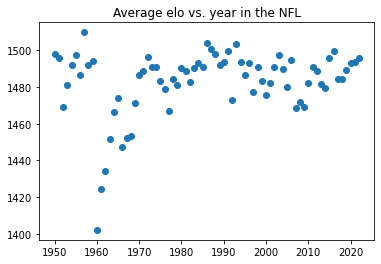

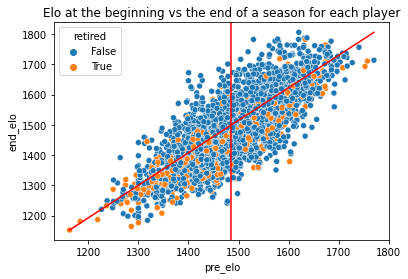

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_final = pd.read_csv('df_qb.csv')

# Create a plot showing the average elo of quarterbacks at the end of each year. Our assumption was that this would increase over the years, but the graph actually shows a rather constant rate of average elos.
plt.scatter(df_final.groupby('season').mean().index,df_final.groupby('season').mean()['end_elo'])
plt.title("Average elo vs. year in the NFL")
plt.show()

sns.scatterplot('pre_elo', 'end_elo', data=df_final, hue='retired')
plt.plot([df_final['pre_elo'].min(),df_final['pre_elo'].max()],[df_final['end_elo'].min(),df_final['end_elo'].max()], c='red')
plt.axvline(sum([df_final['pre_elo'].mean(),df_final['end_elo'].mean()])/2,c='red')
plt.title("Elo at the beginning vs the end of a season for each player")
plt.show()

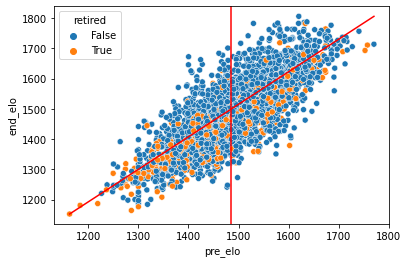

In [ ]:
# Create a plot which compares 
sns.scatterplot('pre_elo', 'end_elo', data=df_final, hue='retired')
plt.plot([df_final['pre_elo'].min(),df_final['pre_elo'].max()],[df_final['end_elo'].min(),df_final['end_elo'].max()], c='red')
plt.axvline(sum([df_final['pre_elo'].mean(),df_final['end_elo'].mean()])/2,c='red')
plt.show()

In [ ]:
def get_acc_sens_spec(y_true, y_pred, verbose=True):
    """ computes sensitivity & specificity (assumed binary inputs)

    Args:
        y_true (np.array): binary ground truth per trial
        y_pred (np.array): binary prediction per trial

    Returns:
        acc (float): accuracy
        sens (float): sensitivity
        spec (float): specificity
    """
    # line below stolen from sklearn confusion_matrix documentation
    tn, fp, fn, tp = confusion_matrix(y_true.astype(bool),
                                      y_pred.astype(bool),
                                      labels=(0, 1)).ravel()

    # compute sensitivity
    if tp + fn:
        sens = tp / (tp + fn)
    else:
        sens = np.nan

    # compute specificity
    if tn + fp:
        spec = tn / (tn + fp)
    else:
        spec = np.nan
        
    # compute acc
    acc = (tp + tn) / (tn + fp + fn + tp)

    return acc, sens, spec

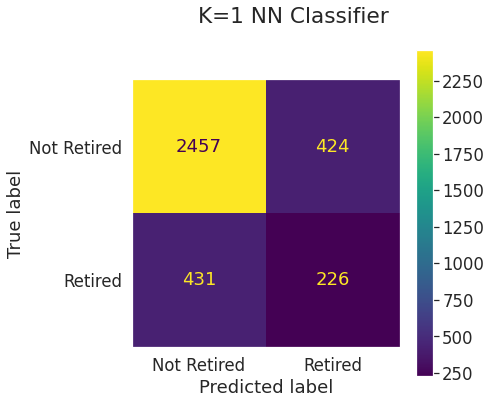

In [ ]:
# KNN ML Algorithm
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from copy import copy


k = 1
x_feat_list = ['pre_elo', 'mid_elo','end_elo', 'previous_seasons', 'season', 'wins', 'losses', 'draws']

df_normalized = df_final.copy()

for feat in x_feat_list:
    df_normalized[feat] = df_normalized[feat] / df_normalized[feat].std()

y_feat = 'retired'

x = df_normalized.loc[:, x_feat_list].values
y_true = df_normalized.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = StratifiedKFold(n_splits=3)

y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    y_pred[test_idx] = knn_classifier.predict(x_test)

# build and plot confusion matrix
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=["Not Retired", "Retired"])

sns.set(font_scale=1.5)
conf_mat_disp.plot()
plt.suptitle('K=1 NN Classifier')
plt.gcf().set_size_inches(6, 6)
plt.grid(False)

In [ ]:
# Get stats about classifier
get_acc_sens_spec(y_true, y_pred)

(0.7583380440927078, 0.3439878234398782, 0.8528288788615064)

(0.7314867156585642, 0.2770167427701674, 0.8351266921207914)
(0.7933860938383267, 0.0852359208523592, 0.9548767788962166)
(0.7687959299039006, 0.2009132420091324, 0.8982992016660881)
(0.7936687394007914, 0.0776255707762557, 0.9569593891010066)
(0.7795364612775579, 0.136986301369863, 0.9260673377299549)
(0.7962125494629735, 0.0441400304414003, 0.9677195418257549)
(0.7868852459016393, 0.0989345509893455, 0.9437695244706699)
(0.7987563595251554, 0.0410958904109589, 0.9715376605345366)
(0.7925381571509327, 0.0821917808219178, 0.9545296771954183)
(0.8032786885245902, 0.0350076103500761, 0.9784796945505033)
(0.7990390050876202, 0.0684931506849315, 0.965636931620965)
(0.8049745618993782, 0.0380517503805175, 0.9798681013536966)
(0.7984737139626907, 0.0578386605783866, 0.9673724401249566)
(0.8061051441492368, 0.0350076103500761, 0.9819507115584867)
(0.8001695873374788, 0.0471841704718417, 0.9718847622353349)
(0.8069530808366309, 0.030441400304414, 0.9840333217632766)
(0.8044092707744488, 0.0441

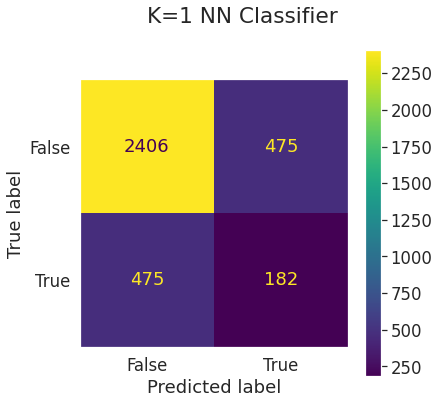

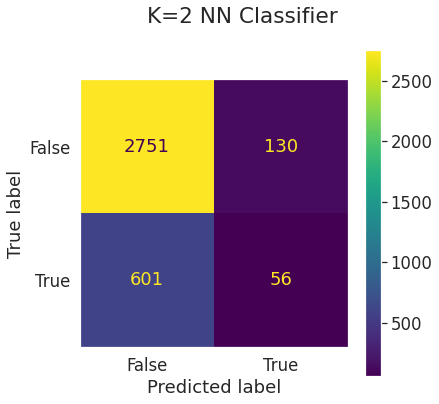

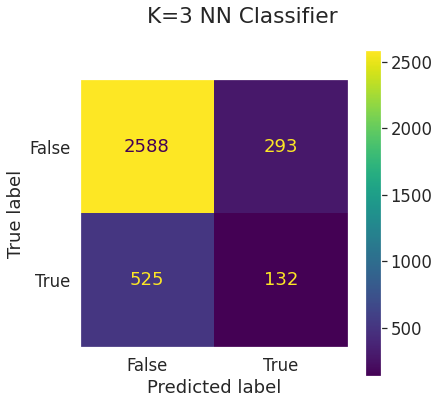

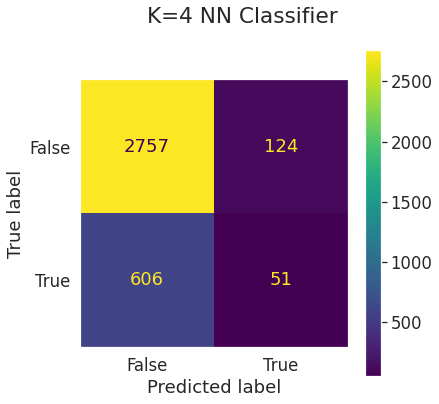

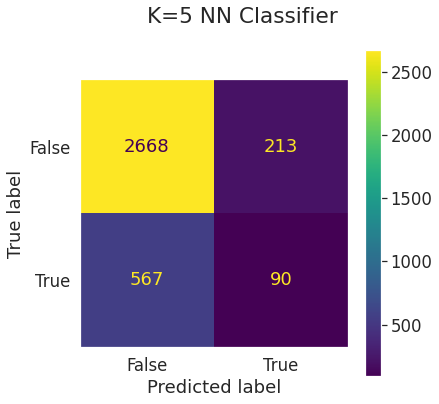

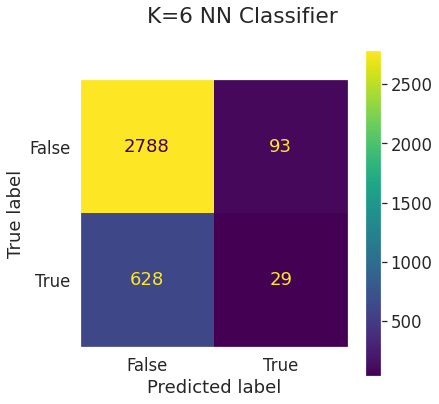

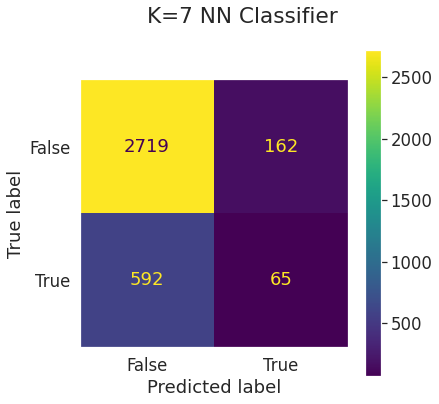

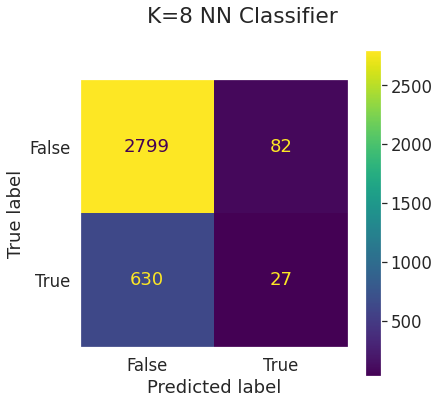

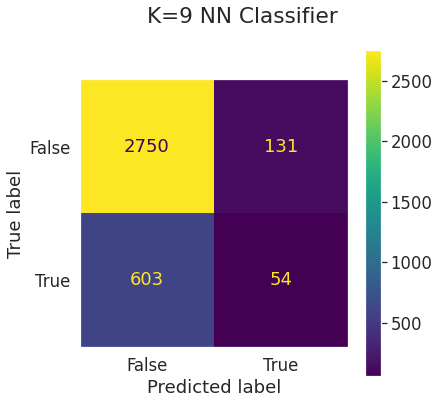

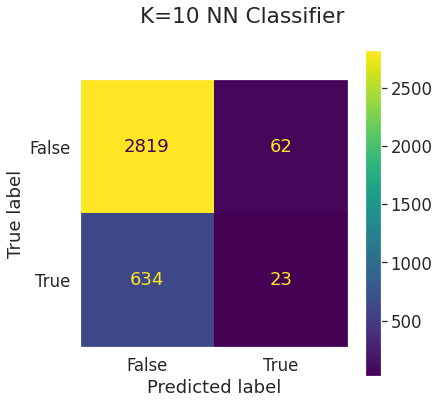

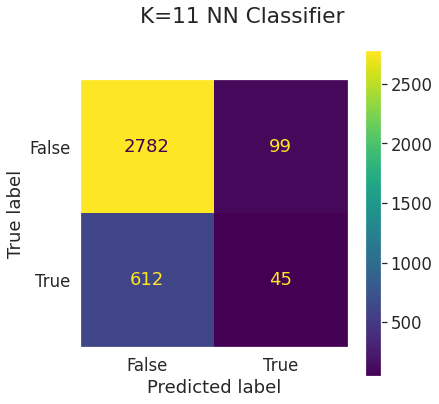

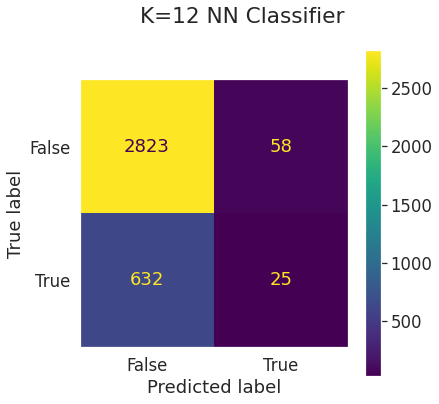

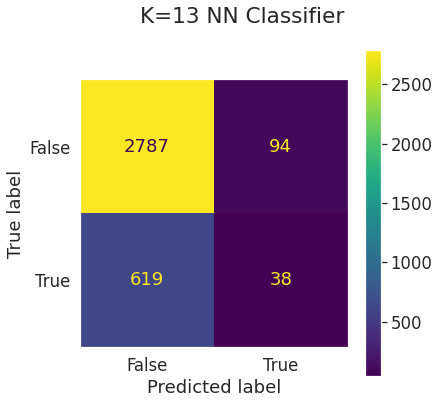

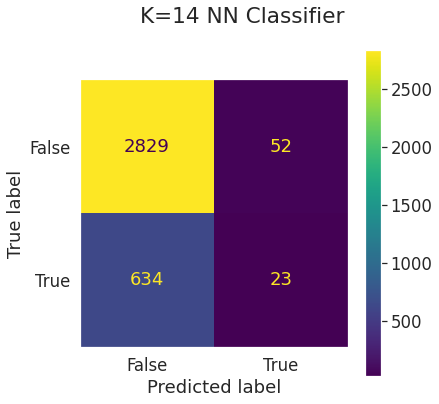

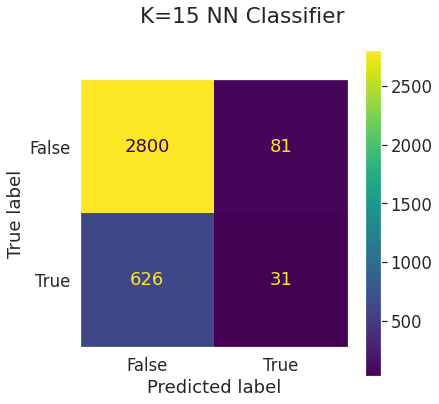

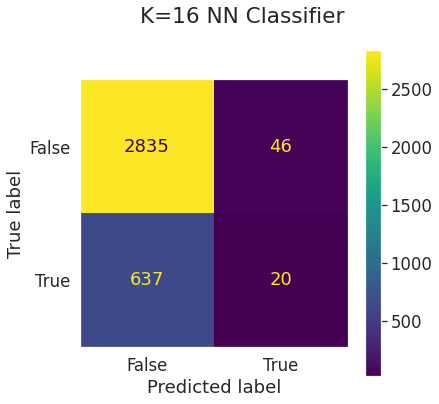

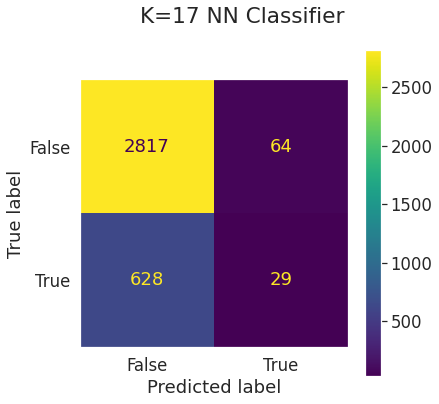

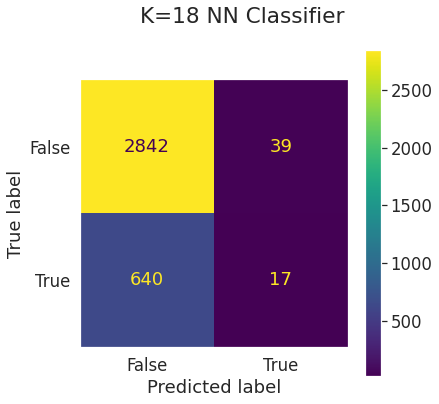

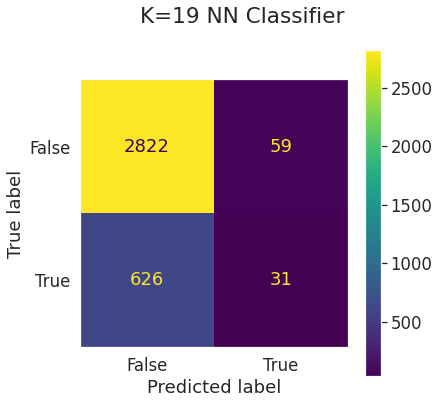

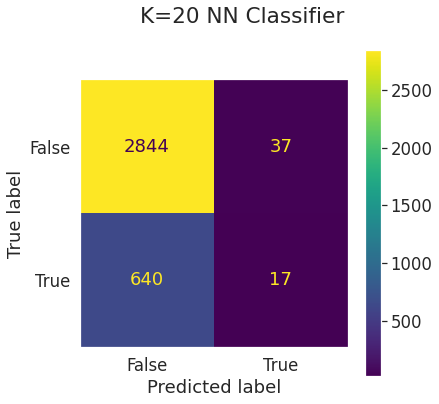

In [ ]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
# Attempt to create a KNN classifier for all k 1-50, and determine which performs the best using confusion matricies
x_feat_list = ['pre_elo', 'mid_elo','end_elo', 'previous_seasons', 'season', 'wins', 'losses', 'draws']
y_feat = 'retired'

x = df_final.loc[:, x_feat_list].values
y_true = df_final.loc[:, y_feat].values

classifiers = []

for i in range(1, 21):
  k = i
  x_feat_list = ['pre_elo', 'mid_elo','end_elo', 'previous_seasons', 'season', 'wins', 'losses', 'draws']
  y_feat = 'retired'

  # initialize a knn_classifier
  knn_classifier = KNeighborsClassifier(n_neighbors=k)

  # construction of kfold object
  kfold = StratifiedKFold(n_splits=3)

  y_pred = copy(y_true)

  for train_idx, test_idx in kfold.split(x, y_true):
      # build arrays which correspond to x, y train /test
      x_test = x[test_idx, :]
      x_train = x[train_idx, :]
      y_true_train = y_true[train_idx]
      
      # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
      knn_classifier.fit(x_train, y_true_train)

      y_pred[test_idx] = knn_classifier.predict(x_test)
  
  conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
  conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
  conf_mat_disp.plot()
  plt.suptitle(f'K={i} NN Classifier')
  plt.gcf().set_size_inches(6, 6)
  plt.grid(False)
  classifiers.append(knn_classifier)
  print(get_acc_sens_spec(y_true, y_pred))



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Hyperparameters
max_depth = None
n_splits = 10
n_estimators = 1000

# X Features
x_feat_list = ['pre_elo', 'mid_elo','end_elo', 'previous_seasons', 'season', 'wins', 'losses', 'draws']
y_feat = 'retired'

# Get x and y
x = df_normalized.loc[:, x_feat_list].values
y = df_normalized.loc[:, y_feat].values

# K-fold object
skfold = StratifiedKFold(n_splits=n_splits)

# Intialize the random forest
rf_retired = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)

# Initialize y_pred
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data    
    x_test = x[test_idx, :]
    
    # fit data
    rf_retired = rf_retired.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = rf_retired.predict(x_test)



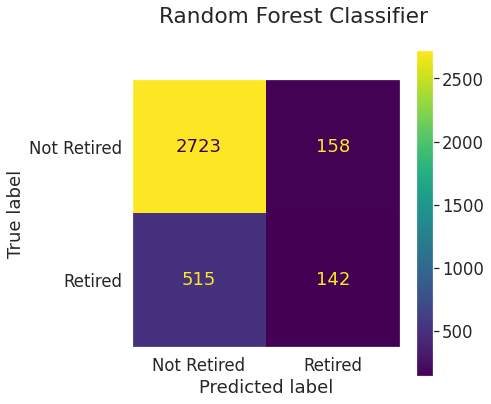

In [ ]:
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=["Not Retired", "Retired"])

sns.set(font_scale=1.5)
conf_mat_disp.plot()
plt.suptitle('Random Forest Classifier')
plt.gcf().set_size_inches(6, 6)
plt.grid(False)

In [ ]:
from sklearn.metrics import  accuracy_score


# Get the accuracy score for the random forest
get_acc_sens_spec(y, y_pred)

(0.8097795364612775, 0.2161339421613394, 0.9451579312738633)

In [ ]:
df_final.loc[df_final['season']==2002]

,qb,season,pre_elo,mid_elo,end_elo,team,wins,losses,draws,previous_seasons,retired,Age,completed passes,attempted passes,copmleted passes %,yards gained,Touchdowns,Touchdoen %,interections
2039,A.J. Feeley,2002,1653.862913,1705.021952,1705.186889,[PHI],4,1,0,0,False,,,,,,,,
855,Aaron Brooks,2002,1453.825402,1563.114972,1492.836806,[NO],9,7,0,2,False,,,,,,,,
2621,Akili Smith,2002,1365.866271,1349.206991,1349.206991,[CIN],0,1,0,3,True,,,,,,,,
3138,Brad Johnson,2002,1541.182314,1622.398209,1718.762208,[TB],13,3,0,6,False,,,,,,,,
3288,Brett Favre,2002,1581.193220,1663.756102,1569.053166,[GB],12,5,0,10,False,,,,,,,,
167,Brian Griese,2002,1529.609271,1586.702486,1538.127051,[DEN],8,5,0,3,False,,,,,,,,
2495,Chad Hutchinson,2002,1413.254938,1419.785945,1368.288167,[DAL],2,7,0,0,False,,,,,,,,
1226,Chad Pennington,2002,1449.209470,1541.851453,1579.797852,[NYJ],9,5,0,0,False,,,,,,,,
742,Chris Chandler,2002,1471.405393,1407.502070,1406.614251,[CHI],2,5,0,14,False,,,,,,,,
3397,Chris Redman,2002,1493.351175,1472.405068,1507.346139,[BAL],3,3,0,0,False,,,,,,,,


In [ ]:
#ranks qbs from first to last, by end_elo, for every season
year_end_rank = pd.DataFrame()
for year in range(df_final['season'].min(),df_final['season'].max()+1):
  year_df = df_final.loc[df_final['season'] == year]
  year_df['end_rank'] = year_df['end_elo'].rank(ascending=False)
  year_end_rank = year_end_rank.append(year_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


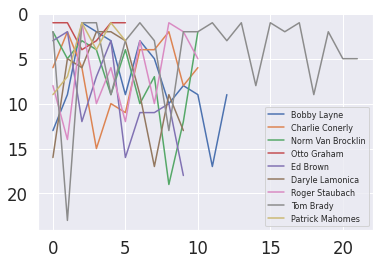

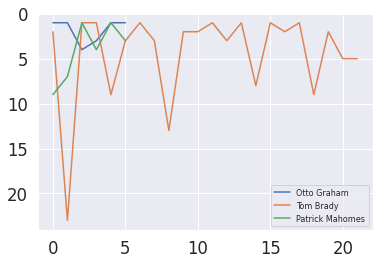

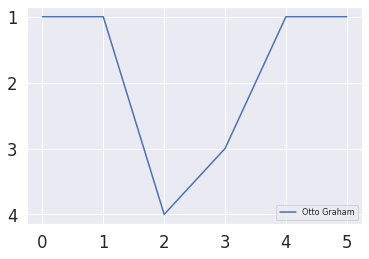

In [ ]:
most_consitient_qb(year_end_rank,16,5,.125)
most_consitient_qb(year_end_rank,10,5,.125)
most_consitient_qb(year_end_rank,4,5,.125)

# Analysis Plan

We can utilize the assumption that all NFL QBs will have the same types statistics, such as Passing Accuracy, Interceptions, and more, so the number of different stats does not change throughout each QB. Thus, to create a metric to compare to the given ELO score, we will have trained a KNN classifier to make it's own predictions for each QB. Unlike the ELO score, this predictive metric will be able to answer the questions that are being asked through this project, such as how have the minimum standards grow each year. The KNN model will use predictive analysis by analyzing the careers of QBs before their final year, and building a model to predict whether a given QB will retire, which unlike the ELO score cannot be accounted for nor predicted as the ELO score is simply an indicator of statistics and not a predictive measure. We believe that this KNN classifier will work best compared to other types of ML algorithms because it will allows us to predict how consistently good a QB is relative to their season and how likely a QB will retire as the minimum standard of skill increases each year. 